In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.0
  [e9467ef8] GLMakie v0.13.6
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [3]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using GLMakie
using HDF5
using JLD2
using LinearAlgebra

In [17]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy, :spink_corrs]
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [18]:
jobname = "fm"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,T,Lx,Ly,Mag,Energy,ηz,ηxy,spink_corrs
,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Array…
1,1.0,40,40,0.9581±0.00076,-34.0787±0.0048,0.978468±6.6e-5,0.003508±5.1e-5,Measurement{Float64}[2.35e6±3700.0 6900.0±1200.0 … 2370.0±310.0 6900.0±1200.0; 6200.0±900.0 5900.0±930.0 … 941.0±79.0 1980.0±190.0; … ; 2300.0±260.0 1040.0±140.0 … 1890.0±260.0 2330.0±330.0; 6200.0±900.0 1980.0±190.0 … 2120.0±280.0 5900.0±930.0]
2,1.25,40,40,0.9477±0.0011,-33.4941±0.0047,0.972687±6.9e-5,0.004169±6.2e-5,Measurement{Float64}[2.2991e6±5100.0 8810.0±990.0 … 2940.0±250.0 8810.0±990.0; 9400.0±1100.0 5280.0±900.0 … 1120.0±94.0 3250.0±540.0; … ; 1760.0±180.0 1190.0±110.0 … 2190.0±250.0 2400.0±220.0; 9400.0±1100.0 3250.0±540.0 … 2310.0±280.0 5280.0±900.0]
3,1.5,40,40,0.9358±0.0012,-32.9101±0.0047,0.966832±6.7e-5,0.004413±5.7e-5,Measurement{Float64}[2.2419e6±5600.0 6350.0±660.0 … 2610.0±330.0 6350.0±660.0; 9100.0±1000.0 11800.0±1400.0 … 1670.0±110.0 3290.0±470.0; … ; 2860.0±310.0 1320.0±110.0 … 2870.0±340.0 3530.0±350.0; 9100.0±1000.0 3290.0±470.0 … 4690.0±540.0 11800.0±1400.0]
4,1.75,40,40,0.9194±0.0013,-32.2921±0.0068,0.96059±0.00011,0.004877±8.5e-5,Measurement{Float64}[2.1641e6±6000.0 13100.0±1300.0 … 3550.0±280.0 13100.0±1300.0; 13400.0±1200.0 16900.0±1200.0 … 1718.0±99.0 3980.0±490.0; … ; 3170.0±300.0 2000.0±200.0 … 3420.0±240.0 4120.0±490.0; 13400.0±1200.0 3980.0±490.0 … 3260.0±350.0 16900.0±1200.0]
5,2.0,40,40,0.9024±0.0035,-31.6583±0.0059,0.954155±8.1e-5,0.005174±6.4e-5,Measurement{Float64}[2.085e6±16000.0 20900.0±5100.0 … 3600.0±550.0 20900.0±5100.0; 19000.0±3800.0 17200.0±2200.0 … 1980.0±230.0 4330.0±460.0; … ; 3580.0±390.0 2180.0±170.0 … 3950.0±340.0 4390.0±420.0; 19000.0±3800.0 4330.0±460.0 … 3980.0±370.0 17200.0±2200.0]
6,2.25,40,40,0.89637±0.00093,-31.0233±0.0059,0.947541±8.3e-5,0.005618±7.3e-5,Measurement{Float64}[2.057e6±4300.0 14800.0±1500.0 … 4080.0±390.0 14800.0±1500.0; 16400.0±1900.0 12800.0±1600.0 … 2750.0±250.0 5810.0±630.0; … ; 4560.0±350.0 2920.0±250.0 … 3830.0±470.0 5860.0±490.0; 16400.0±1900.0 5810.0±630.0 … 5150.0±680.0 12800.0±1600.0]
7,2.5,40,40,0.8818±0.0021,-30.3806±0.0086,0.94089±0.0001,0.005976±6.6e-5,Measurement{Float64}[1.9908e6±9600.0 16000.0±2000.0 … 4010.0±430.0 16000.0±2000.0; 12170.0±900.0 24000.0±3600.0 … 2520.0±160.0 6640.0±670.0; … ; 4400.0±370.0 2760.0±190.0 … 4610.0±380.0 5490.0±540.0; 12170.0±900.0 6640.0±670.0 … 6710.0±400.0 24000.0±3600.0]
8,2.75,40,40,0.8636±0.0035,-29.6882±0.0069,0.9335±7.9e-5,0.006297±5.5e-5,Measurement{Float64}[1.91e6±15000.0 14700.0±1800.0 … 5380.0±610.0 14700.0±1800.0; 25400.0±3300.0 21200.0±3600.0 … 3660.0±420.0 6790.0±440.0; … ; 5210.0±780.0 3110.0±190.0 … 4390.0±350.0 7780.0±710.0; 25400.0±3300.0 6790.0±440.0 … 7240.0±680.0 21200.0±3600.0]
9,3.0,40,40,0.8494±0.0024,-28.958±0.0062,0.925632±8.1e-5,0.006645±6.5e-5,Measurement{Float64}[1.848e6±11000.0 22600.0±4100.0 … 6540.0±710.0 22600.0±4100.0; 21000.0±2400.0 18700.0±1800.0 … 3260.0±120.0 7510.0±600.0; … ; 5620.0±520.0 3650.0±280.0 … 5040.0±490.0 7540.0±670.0; 21000.0±2400.0 7510.0±600.0 … 8250.0±750.0 18700.0±1800.0]


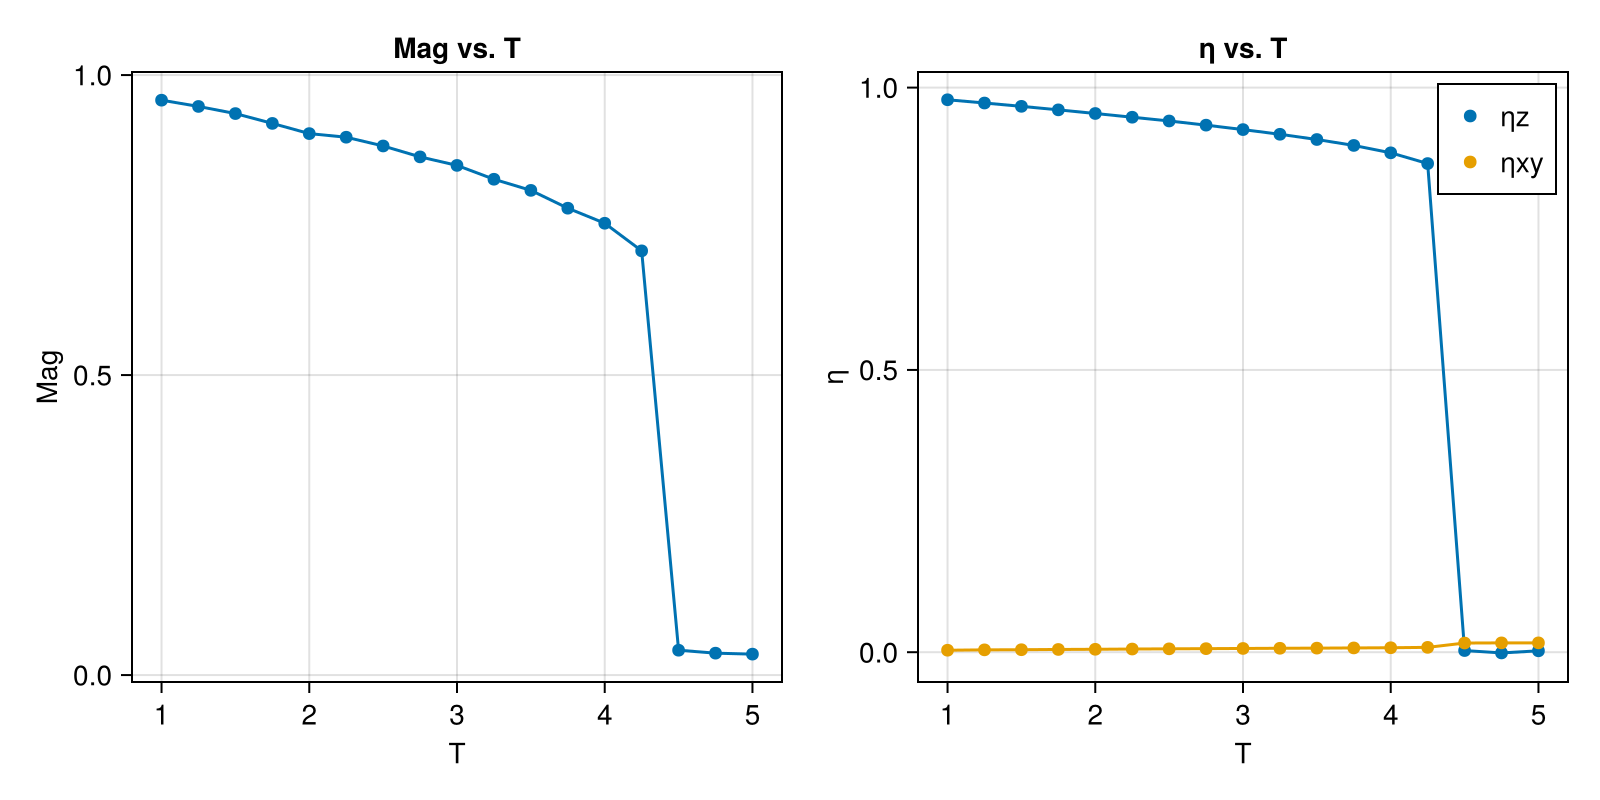

In [12]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

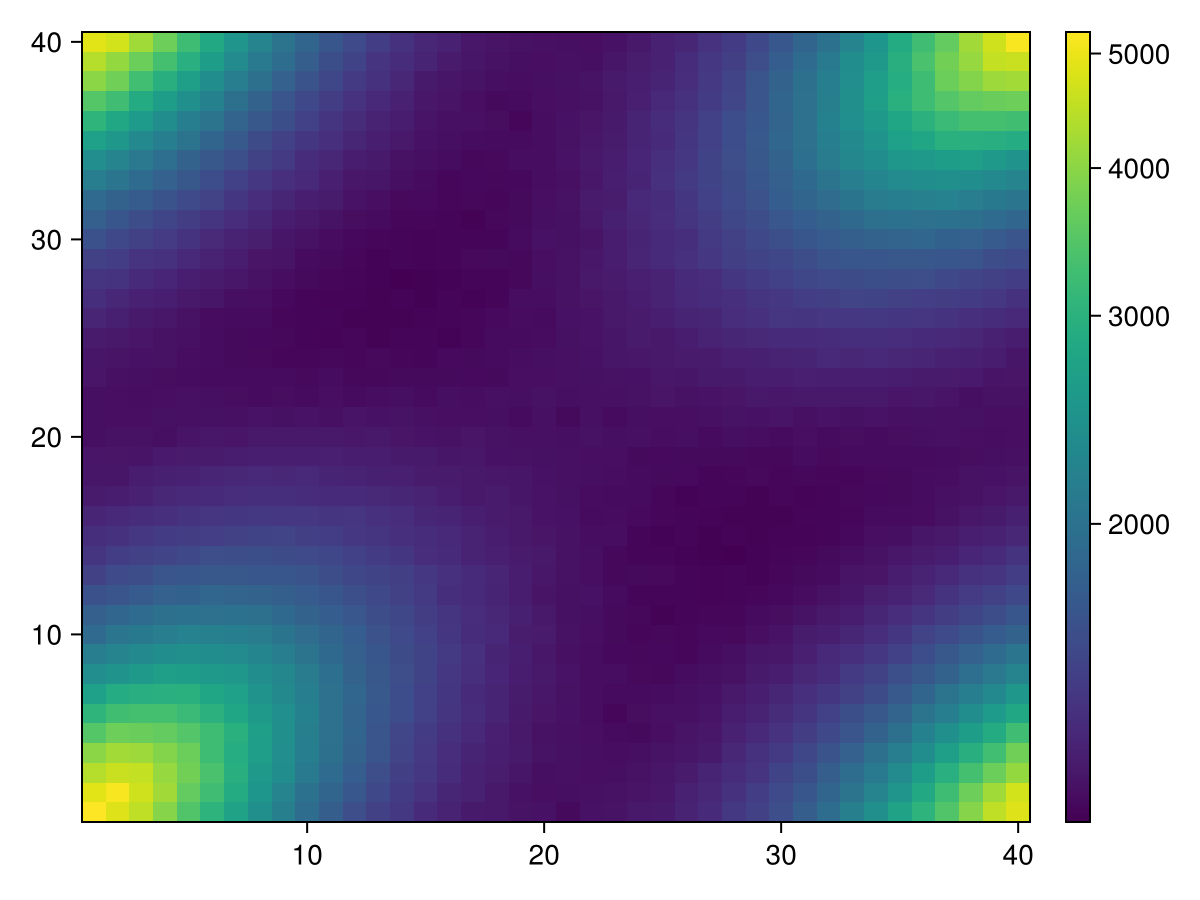

In [24]:
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
spink_corrs = getfield.(data[15, :spink_corrs], :val)
fig, ax, hm = heatmap(spink_corrs, colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

In [13]:
function generate_mctime_plot(task_no::Int, fig=Figure(size=(800, 400)), fig_pos=(1, 1))
    ax_P = fig[fig_pos...] = Axis(
        fig,
        title="Magnetization vs. Bin #",
        xlabel="Bin #",
        ylabel="Magnetization",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        mag_samples = read(observables, "Mag/samples")
        n = length(mag_samples)
        init = 1
        lines!(
            ax_P,
            collect(1:n),
            mag_samples[1:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

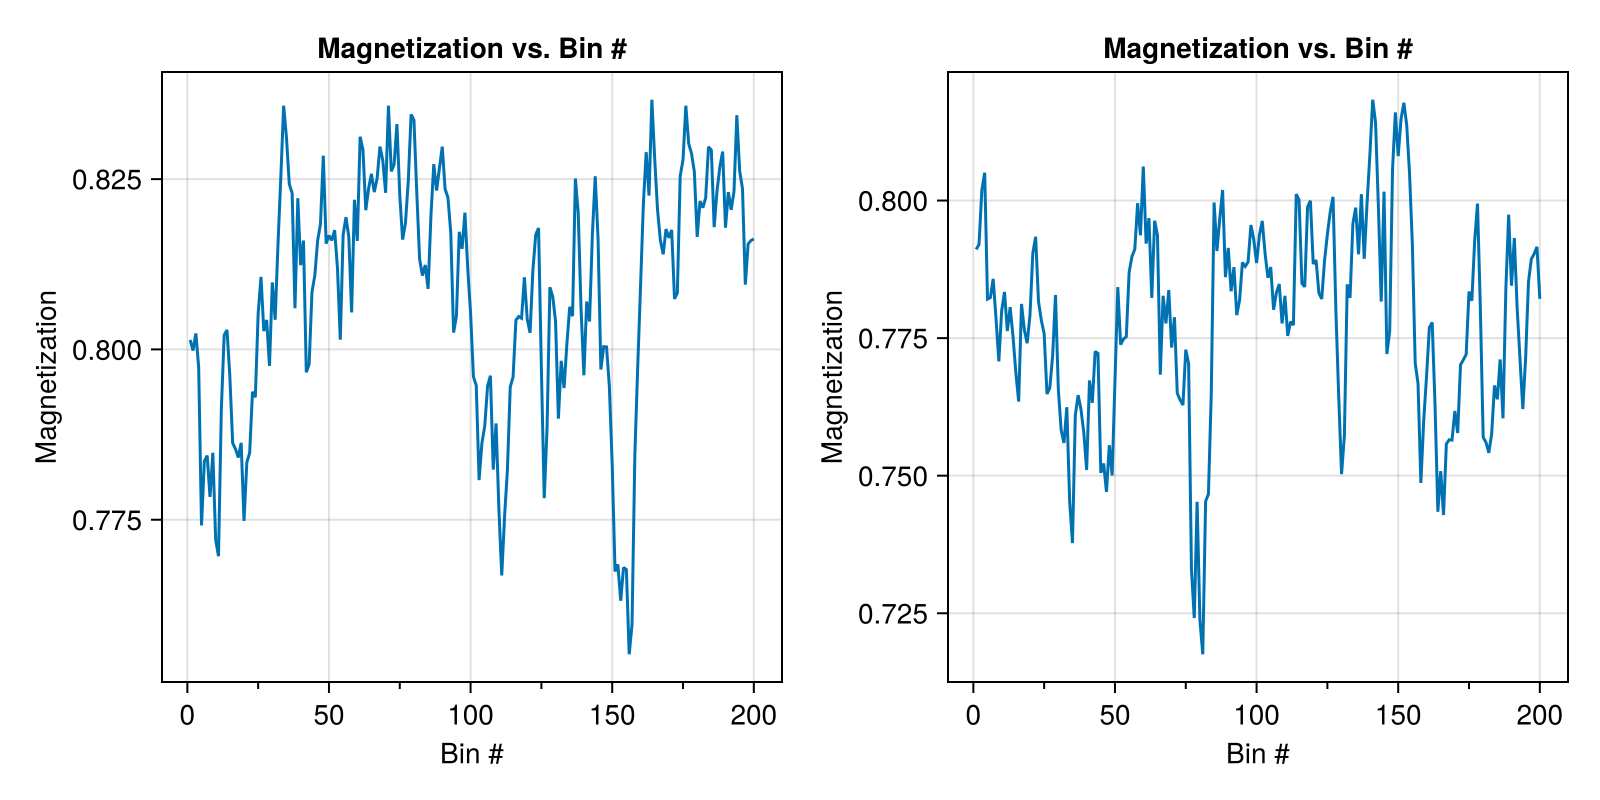

In [27]:
fig = Figure(size=(400, 800))
i = 11
fig = generate_mctime_plot(i)
generate_mctime_plot(i+1, fig, (1, 2))

In [15]:
function generate_spins(task_no::Int)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## Annealed Random Initial State

In [14]:
anneal_results = JobResult("../jobs", "fm-anneal")

JobResult("../jobs", "fm-anneal", 17×24 DataFrame
 Row │ ηz                T        init_T  etak_corrs                         _ ⋯
     │ Measurem…         Float64  Int64   Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.97852±0.0001      1.0       10  Complex{Measurement{Float64}}[5.…  0 ⋯
   2 │  0.97282±0.00012     1.25      10  Complex{Measurement{Float64}}[6.…  0
   3 │  0.96679±0.00012     1.5       10  Complex{Measurement{Float64}}[8.…  0
   4 │  0.960747±9.1e-5     1.75      10  Complex{Measurement{Float64}}[9.…  0
   5 │  0.6252±0.0095       2.0       10  Complex{Measurement{Float64}}[13…  0 ⋯
   6 │  0.94724±0.00014     2.25      10  Complex{Measurement{Float64}}[12…  0
   7 │ -0.94082±0.00023     2.5       10  Complex{Measurement{Float64}}[14…  0
   8 │  0.93335±0.00017     2.75      10  Complex{Measurement{Float64}}[15…  0
  ⋮  │        ⋮             ⋮       ⋮                     ⋮            

In [15]:
anneal_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.0004248±8.6e-6,0.0002±4.0e-5
2,0.00040904±3.7e-7,0.000149±1.4e-5
3,0.0004107±1.2e-6,0.000157±1.5e-5
4,0.00041025±5.0e-7,0.0001402±8.1e-6
5,0.00040981±6.1e-7,0.000157±1.3e-5
6,0.00040959±2.0e-7,0.0001346±6.1e-6
7,0.000412±1.6e-6,0.000161±1.6e-5
8,0.00041112±6.3e-7,0.000163±2.0e-5
9,0.00041105±4.9e-7,0.000141±1.1e-5


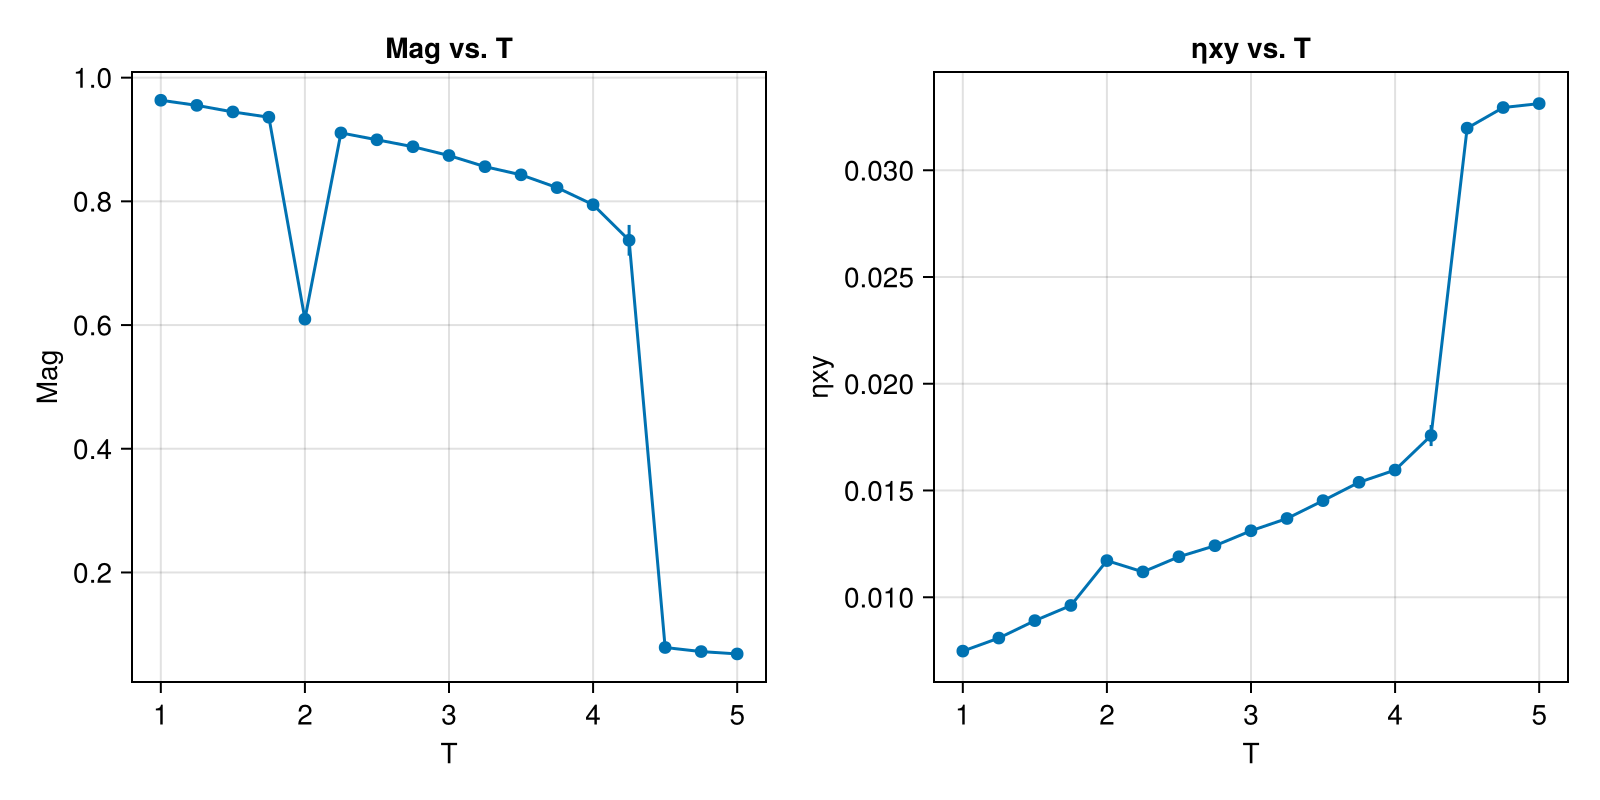

In [ ]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, anneal_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηz, anneal_results; line=true)
fig

In [17]:
anneal_mctimes = get_mctime_data(anneal_results, :Mag, :ηxy)

17-element Vector{DataFrame}:
 200×2 DataFrame
 Row │ Mag       ηxy        
     │ Float64   Float64    
─────┼──────────────────────
   1 │ 0.955821  0.00566686
   2 │ 0.962263  0.00850868
   3 │ 0.964828  0.00425563
   4 │ 0.966814  0.0088259
   5 │ 0.967109  0.0075005
   6 │ 0.965758  0.00413058
   7 │ 0.965762  0.00787774
   8 │ 0.963533  0.00861181
  ⋮  │    ⋮          ⋮
 194 │ 0.966709  0.00764732
 195 │ 0.962938  0.00584311
 196 │ 0.964612  0.00497937
 197 │ 0.968472  0.00856931
 198 │ 0.969448  0.00862758
 199 │ 0.968774  0.00790818
 200 │ 0.965559  0.00939641
            185 rows omitted
 200×2 DataFrame
 Row │ Mag       ηxy        
     │ Float64   Float64    
─────┼──────────────────────
   1 │ 0.948993  0.0130256
   2 │ 0.951014  0.00515005
   3 │ 0.951193  0.00857923
   4 │ 0.953176  0.00648536
   5 │ 0.952372  0.00995232
   6 │ 0.95568   0.00798518
   7 │ 0.956602  0.00748263
   8 │ 0.955637  0.0102535
  ⋮  │    ⋮          ⋮
 194 │ 0.966334  0.00797668
 195 │ 0.965474  0.

In [18]:
GLMakie.activate!()

fig = Figure()
fig[1,1] = ax = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
sg = SliderGrid(
    fig[2, 1],
    (label="Task #", range=1:17, format="{:.1f}", startvalue=1, update_while_dragging=false)
)
slider = sg.sliders[1]
mcdata = lift(slider.value) do i
    anneal_mctimes[i][:, :ηxy]
end
on(mcdata) do mcdata
    empty!(ax)
    lines!(ax, 1:400, mcdata)
    autolimits!(ax)
end
fig

In [19]:
spink_corrs = anneal_results[:spink_corrs]

17-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [148520.0 ± 270.0 478.0 ± 51.0 … 118.0 ± 10.0 478.0 ± 51.0; 614.0 ± 93.0 391.0 ± 53.0 … 68.0 ± 4.5 162.0 ± 17.0; … ; 111.1 ± 8.9 60.3 ± 3.4 … 115.2 ± 9.8 169.0 ± 15.0; 614.0 ± 93.0 162.0 ± 17.0 … 165.0 ± 14.0 391.0 ± 53.0]
 [145980.0 ± 270.0 653.0 ± 65.0 … 140.3 ± 8.5 653.0 ± 65.0; 546.0 ± 60.0 466.0 ± 55.0 … 83.7 ± 5.0 208.0 ± 24.0; … ; 141.0 ± 5.1 100.0 ± 6.0 … 124.8 ± 8.6 213.0 ± 23.0; 546.0 ± 60.0 208.0 ± 24.0 … 189.0 ± 18.0 466.0 ± 55.0]
 [142760.0 ± 300.0 828.0 ± 85.0 … 186.8 ± 9.5 828.0 ± 85.0; 579.0 ± 70.0 685.0 ± 73.0 … 97.1 ± 5.7 240.0 ± 18.0; … ; 200.0 ± 11.0 96.1 ± 3.7 … 173.0 ± 12.0 269.0 ± 27.0; 579.0 ± 70.0 240.0 ± 18.0 … 217.0 ± 10.0 685.0 ± 73.0]
 [140180.0 ± 240.0 835.0 ± 83.0 … 212.0 ± 14.0 835.0 ± 83.0; 654.0 ± 57.0 643.0 ± 60.0 … 118.4 ± 5.5 276.0 ± 19.0; … ; 212.0 ± 13.0 123.0 ± 6.9 … 225.0 ± 16.0 342.0 ± 21.0; 654.0 ± 57.0 276.0 ± 19.0 … 269.0 ± 20.0 643.0 ± 60.0]
 [59700.0 ± 1800.0 8920.0 ± 430.0 … 8

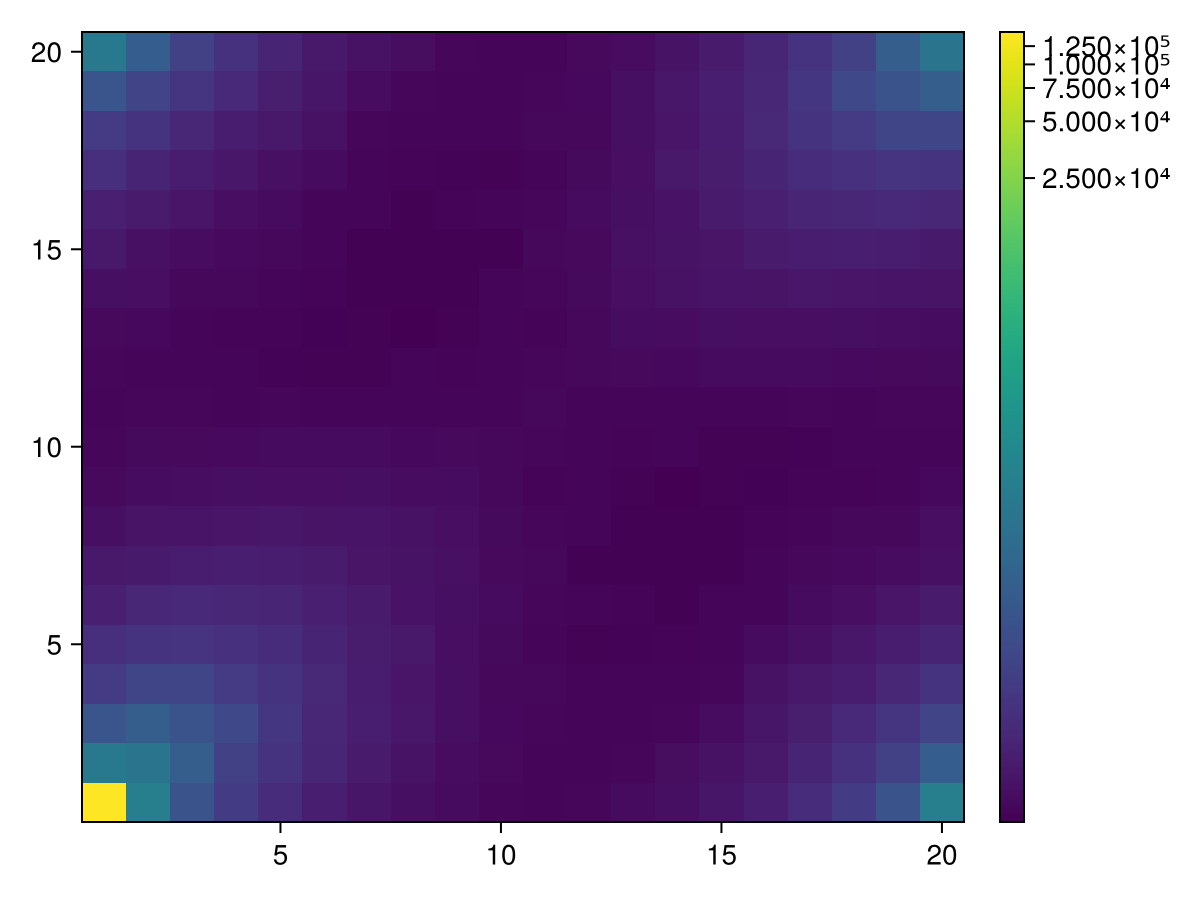

In [20]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

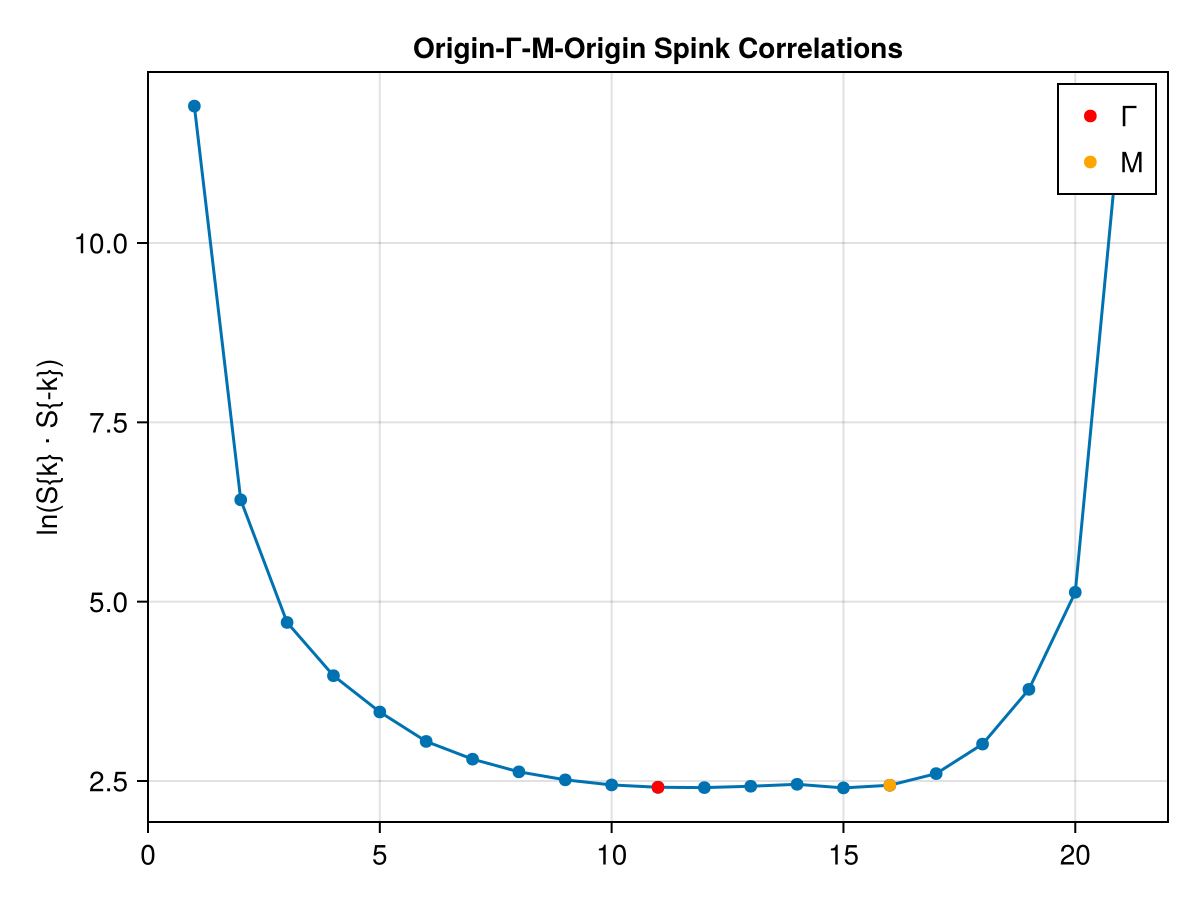

In [21]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

Γ_path = [(i, 1) for i in 1:borderx]
M_path = [(borderx, i) for i in 2:(div(bordery, 2) + 1)]
O_path = [(borderx - 2i, div(bordery, 2) - i + 1) for i in 1:div(borderx, 2)]
path = cat(Γ_path, M_path, O_path, dims=1)

Γ_pos = length(Γ_path)
M_pos = length(Γ_path) + length(M_path)
corrs = [spink_corrs[1][I...] for I in path]

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
scatter!(ax, log.(corrs))
lines!(ax, log.(corrs))
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

In [22]:
to_triangle((x, y)) = ((x-1), (-(x-1) + 2(y-1)) / sqrt(3)) ./ 20
positions = to_triangle.(Iterators.product(axes(getfield.(spink_corrs[1], :val))...))

20×20 Matrix{Tuple{Float64, Float64}}:
 (0.0, 0.0)          …  (0.0, 1.03923)    (0.0, 1.09697)
 (0.05, -0.0288675)     (0.05, 1.01036)   (0.05, 1.0681)
 (0.1, -0.057735)       (0.1, 0.981495)   (0.1, 1.03923)
 (0.15, -0.0866025)     (0.15, 0.952628)  (0.15, 1.01036)
 (0.2, -0.11547)        (0.2, 0.92376)    (0.2, 0.981495)
 (0.25, -0.144338)   …  (0.25, 0.894893)  (0.25, 0.952628)
 (0.3, -0.173205)       (0.3, 0.866025)   (0.3, 0.92376)
 (0.35, -0.202073)      (0.35, 0.837158)  (0.35, 0.894893)
 (0.4, -0.23094)        (0.4, 0.80829)    (0.4, 0.866025)
 (0.45, -0.259808)      (0.45, 0.779423)  (0.45, 0.837158)
 (0.5, -0.288675)    …  (0.5, 0.750555)   (0.5, 0.80829)
 (0.55, -0.317543)      (0.55, 0.721688)  (0.55, 0.779423)
 (0.6, -0.34641)        (0.6, 0.69282)    (0.6, 0.750555)
 (0.65, -0.375278)      (0.65, 0.663953)  (0.65, 0.721688)
 (0.7, -0.404145)       (0.7, 0.635085)   (0.7, 0.69282)
 (0.75, -0.433013)   …  (0.75, 0.606218)  (0.75, 0.663953)
 (0.8, -0.46188)        (0.8, 0.5

In [23]:
GLMakie.activate!()
xs = 10 .* getindex.(positions, 1)
ys = 10 .* getindex.(positions, 2)
surface(xs, ys, log.(getfield.(spink_corrs[2], :val)))